[View in Colaboratory](https://colab.research.google.com/github/tompc35/ms274-modeling-marine-systems/blob/master/NPZ_model.ipynb)

# NPZ (nutrient-phytoplankton-zooplankton) model

Exploring a zero-dimensional, three component ecosystem model.

$\partial N/ \partial t =  -\frac{V_m N P}{K_s + N} + gZ  + \gamma R_m \frac{P}{K_G + P}$

$ \partial P /\partial t = \frac{V_m N P}{K_s + N} - R_m \frac{P}{K_G + P} Z - mP$

$\partial Z / \partial t = (1 - \gamma)R_m \frac{P}{K_G + P} Z - gZ$

The formulation above uses a Michaelis-Menten functional type for the specific zooplankton ingestion rate, $I$. Other functional types can be specified.


In [0]:
import numpy as np
from matplotlib import pyplot as plt

## Select parameters and zooplankton predation type 

#### Specify parameter values

Default values from Franks et al. (1986):

```
Vm = 2.      # max phtyoplankton growth rate
Rm = 1.5     # max zooplankton ingestion rate
ks = 1.      # half-saturation constant for phytoplankton N uptake 
m = 0.1      # phytoplankton mortality
kg = 1.      # grazing half saturation or (1/Ivlev constant)
gamma = 0.2  # unassimilated phytoplankton fraction
g = 0.2      # zooplankton mortality
```

In [0]:
Vm = 2.      # max phtyoplankton growth rate [days^-1]
Rm = 1.      # max zooplankton ingestion rate [days^-1]
ks = 1.      # half-saturation constant for phytoplankton N uptake [umol/L]
m = 0.1      # phytoplankton mortality [days^-1]
kg = 1.      # grazing half saturation or (1/Ivlev constant) [umol/L]
gamma = 0.2  # unassimilated phytoplankton fraction []
g = 0.2      # zooplankton mortality [days^-1]

#### Specify zooplankton predation functional type

Options:
* `'M-M'` (Michaelis-Menten, *default*)

$$ I = R_m \frac{P}{k_g+P} $$

* `'quadratic'`

$$ I = R_m \frac{P^2}{k_g^2+P^2} $$

* `'Ivlev'`

$$ I = R_m\left[1-\exp(-k_g^{-1}P) \right] $$

* `'M-P'` (Mayzaud-Poulet)

$$ I = R_m k_g^{-1}P \left[1-\exp(-k_g^{-1}P) \right] $$

In [0]:
predation_type = 'M-M' 

## Define time step and initial conditions

In [0]:
tmax = 50  # maximum time [days]
dt = 0.0001 # time step [days]
t = np.arange(0,tmax,dt)

# initialize arrays of NaNs for all times
P = np.nan*t # phytoplankton
N = np.nan*t # nitrate
Z = np.nan*t # zooplankton

Initial conditions at time $t = 0$

In [0]:
P[0] = 1
N[0] = 3
Z[0] = 1

## Zooplankton ingestion function

Zooplankton specific ingestion rate as a function of phytoplankton concentration. This is a functional relationship defined by the model parameters, and does not change with time.

In [0]:
def ingestion(P,Rm,kg,predation_type):
    '''
    This function calculates the zooplankton ingestion rate, I, which 
    depends on the phytoplankton biomass (P), the maximum zooplankton ingestion 
    rate (Rm), the half-saturation/Ivlev parameter (kg) and the predation type.
    
    The predatation type should be 'M-M', 'quadratic', 'Ivlev' or 'M-P'. 
    '''
    
    if predation_type == 'quadratic':
        I = Rm*P**2/(kg**2+P**2)
    elif predation_type == 'Ivlev':
        I = Rm*(1-np.exp(-kg**-1*P))
    elif predation_type == 'M-P':
        I = Rm*kg**-1*P*(1-np.exp(-kg**-1*P))
    else:
        I = Rm*P/(kg+P)
    return I

Text(0,0.5,u'Z specific ingestion rate I [day$^{-1}$]')

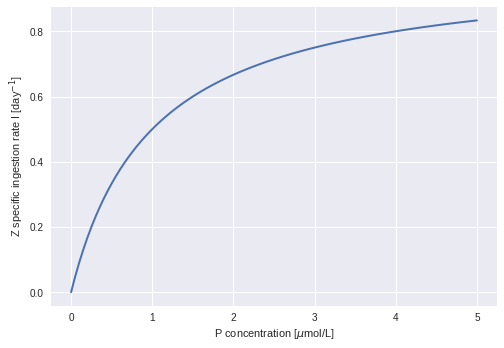

In [38]:
NT = P[0]+N[0]+Z[0]
Pf = np.linspace(0,NT,100)
If = ingestion(Pf,Rm,kg,predation_type)

plt.figure()
plt.plot(Pf,If,lw=2)
plt.xlabel('P concentration [$\mu$mol/L]')
plt.ylabel('Z specific ingestion rate I [day$^{-1}$]')

## Phytoplankton growth function

Phtyoplankton specific growth rate as a function of nutrient concentration. This is a functional relationship defined by the model parameters, and does not change with time.

In [0]:
def phyto_growth_rate(N,Vm,ks):
    '''
    This function calculates the phytoplankton growth rate, mu, which 
    depends on the nutrient concentration (N), the maximum phytoplankton growth
    rate (Vm), the half-saturation concentration (ks).
    '''
    
    mu = Vm*N/(ks+N) # growth rate [day^-1]
    return mu

Text(0,0.5,u'P specific growth rate $\\mu$ [day$^{-1}$]')

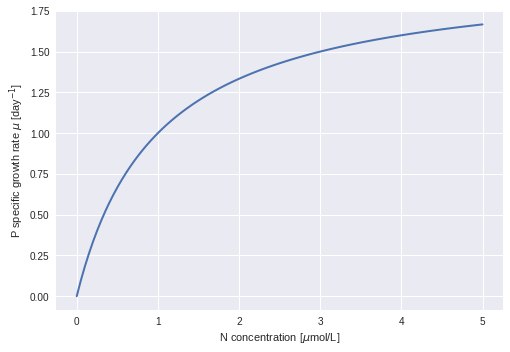

In [40]:
Nf = np.linspace(0,NT,100)
muf = phyto_growth_rate(Nf,Vm,ks)

plt.figure()
plt.plot(Nf,muf,lw=2)
plt.xlabel('N concentration [$\mu$mol/L]')
plt.ylabel('P specific growth rate $\mu$ [day$^{-1}$]')

## Model calculations

Starting from initial conditions and using a loop to step forward in time (Euler's method).

In [0]:
for i,time in enumerate(t[1:]):   
    mu = phyto_growth_rate(N[i],Vm,ks)
    I = ingestion(P[i],Rm,kg,predation_type)
    
    prod = P[i]*mu # production rate
    remin = P[i]*m # remineralization rate of phytoplankton
    grazing = I*Z[i] # zooplanton grazing rate
    zmort = g*Z[i] # zooplankton mortality rate
    
    P[i+1] = P[i] + (prod - remin - grazing)*dt
    N[i+1] = N[i] + (-prod + remin + zmort + gamma*grazing)*dt
    Z[i+1] = Z[i] + ((1-gamma)*grazing - zmort)*dt

## Time series plots of nitrogen, phytoplankton and zooplankton

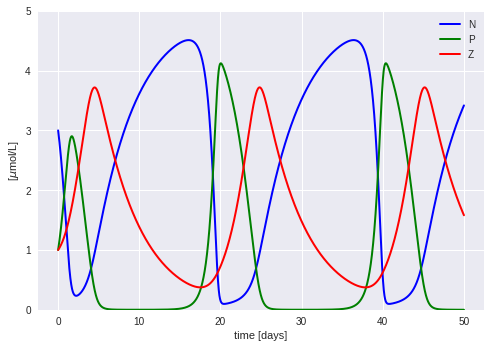

In [42]:
plt.figure()
plt.plot(t,N,color='b',lw=2)
plt.plot(t,P,color='g',lw=2)
plt.plot(t,Z,color='r',lw=2)
plt.ylim([0,NT])
plt.xlabel('time [days]')
plt.ylabel('[$\mu$mol/L]')
plt.legend(['N','P','Z'],loc='best')

# Phase plane diagram

Co-variation of phytoplankton and zooplankton

Text(0,0.5,u'Z')

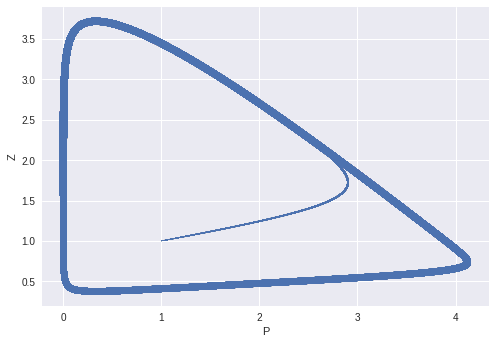

In [48]:
plt.figure()
plt.scatter(P,Z,t)
plt.xlabel('P')
plt.ylabel('Z')